In [1]:
import numpy as np
import pandas as pd

In [2]:
from absa_code import preprocessing_pipelines

In [3]:
from absa_code.models.lda import LDA
from absa_code.models.llda import LLDA
# from absa_code.models.mylda import MLDA
from absa_code.models.mlda import MLDA

In [4]:
review_data, label_matrix = preprocessing_pipelines.lda_text_pipeline()
review_data.head(10)

,review,opinion_data
0,Judging from previous posts this used to be a ...,category from polarity target ...
1,"We, there were four of us, arrived at noon - t...",category from polarity target to ...
2,"They never brought us complimentary noodles, i...",category from polarity target to ...
3,The food was lousy - too sweet or too salty an...,category from polarity targe...
4,"After all that, they complained to me about th...",category from polarity target to ...
5,Avoid this place!,category from polarity target ...
6,"I have eaten at Saul, many times, the food is ...",category from polarity target to 0 ...
7,Saul is the best restaurant on Smith Street an...,category from polarity target ...
8,The duck confit is always amazing and the foie...,category from polarity ...
9,The wine list is interesting and has many good...,category from polarity ta...


In [5]:
from sklearn.feature_extraction.text import CountVectorizer

# cv = CountVectorizer(stop_words='english')
cv = CountVectorizer(min_df=0)
X = cv.fit_transform(review_data['review'])
X[0].toarray()

array([[0, 0, 0, ..., 0, 0, 0]])

In [6]:
vocab = pd.Series(cv.get_feature_names())

In [7]:
vocab_size = X.shape[1]
vocab_size

3038

In [8]:
unique_categories = set()
for i, doc in review_data.iterrows():
    category = doc['opinion_data']['category'][0]
    unique_categories.add(category)

In [9]:
categories_arr = np.array(list(unique_categories))
categories_arr

array(['AMBIENCE#GENERAL', 'FOOD#PRICES', 'DRINKS#STYLE_OPTIONS',
       'RESTAURANT#PRICES', 'RESTAURANT#MISCELLANEOUS', 'DRINKS#QUALITY',
       'SERVICE#GENERAL', 'DRINKS#PRICES', 'FOOD#QUALITY',
       'LOCATION#GENERAL', 'FOOD#STYLE_OPTIONS', 'RESTAURANT#GENERAL'],
      dtype='<U24')

#### Calculate cluster ("label") matrix

In [10]:
np.argwhere(categories_arr == 'RESTAURANT#GENERAL')

array([[11]])

In [11]:
label_matrix = np.zeros(shape=(review_data.shape[0], 12))
for i, doc in review_data.iterrows():
    targets = doc['opinion_data']
    for j, target in targets.iterrows():
        k = np.argwhere(categories_arr == target['category'])
        label_matrix[i][k] = 1

#### Calculate word-topic counts in data

In [12]:
vocab_set = set(cv.get_feature_names())
'waitress' in vocab_set

True

In [13]:
word_k_matrix = np.zeros(shape=(X.shape[1], 12))
for j, doc in review_data.iterrows():
    targets = doc['opinion_data']
    for i, target in targets.iterrows():
        k = np.argwhere(categories_arr == target['category'])
        word = target['target']
        word = word.lower()
        word = word.split(' ')
        for w in word:
            if w in vocab_set:
                j = vocab[vocab == w].index[0]
                word_k_matrix[j,k] += 1

In [14]:
word_k_matrix / np.sum(word_k_matrix)

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.00037722, 0.        , 0.        , ..., 0.        , 0.        ,
        0.00037722],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00037722]])

In [15]:
label_matrix[3]

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.])

In [16]:
np.random.choice(np.argwhere(label_matrix[3] == 1).reshape(-1,))

8

# MLDA

In [17]:
binary_word_k_matrix = word_k_matrix[:]
binary_word_k_matrix[binary_word_k_matrix == 0] += 0.001

In [172]:
llda = MLDA(0.005, 0.08, 12)

In [173]:
llda.random_initialization(review_data['review'][:50], word_k_matrix)
llda.vocab_size

252

In [174]:
print('n_dk: {}'.format(llda.n_dk.shape))
print('n_wk: {}'.format(llda.n_wk.shape))

n_dk: (50, 12)
n_wk: (252, 12)


In [175]:
orig_z = llda.z

In [176]:
label_matrix.shape

(1708, 12)

In [177]:
log_likelihoods = llda.fit(max_iters=1000)

0
100
200
300
400
500
600
700
800
900


In [186]:
t = 900
np.corrcoef(np.array([log_likelihoods[:-t], log_likelihoods[t:]]))

array([[1.        , 0.09713741],
       [0.09713741, 1.        ]])

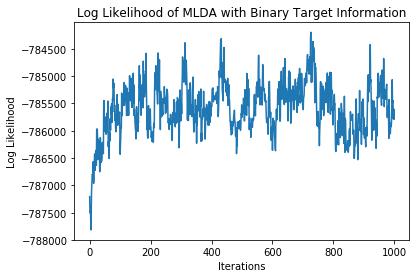

In [113]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(log_likelihoods)
plt.xlabel('Iterations')
plt.ylabel('Log Likelihood')
plt.title('Log Likelihood of MLDA with Binary Target Information')
plt.savefig('mlda.png', dpi=200)

In [114]:
beta = llda.calc_beta()
theta = llda.calc_theta()

In [115]:
beta.shape

(252, 12)

In [116]:
theta.shape

(50, 12)

In [117]:
np.unique(llda.z)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [118]:
np.unique(llda.z[3])

array([0, 8])

In [119]:
theta[3]

array([1.55250574e-05, 1.55250574e-05, 1.55250574e-05, 1.55250574e-05,
       1.55250574e-05, 1.55250574e-05, 1.55250574e-05, 1.55250574e-05,
       1.86455940e-02, 1.55250574e-05, 1.55250574e-05, 1.55250574e-05])

### Get most common words

For topic 6:

In [120]:
import pandas as pd

In [121]:
word_freq_inds = np.argsort(llda.n_wk[:, 3]) #least to most
word_features = pd.Series(llda.corpus_model.get_feature_names())

In [122]:
word_freq_inds

array([  0, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161,
       162, 163, 164, 165, 166, 168, 169, 170, 171, 172, 176, 177, 178,
       149, 148, 147, 146, 119, 120, 121, 122, 123, 124, 250, 126, 127,
       128, 129, 130, 179, 131, 133, 134, 135, 136, 137, 138, 139, 140,
       141, 143, 144, 145, 132, 118, 180, 183, 218, 219, 220, 221, 223,
       224, 225, 226, 227, 228, 229, 231, 233, 234, 235, 237, 238, 239,
       240, 241, 242, 244, 245, 246, 248, 217, 216, 215, 214, 184, 185,
       186, 187, 188, 190, 191, 193, 194, 195, 196, 197, 182, 199, 201,
       202, 203, 204, 205, 206, 207, 208, 209, 210, 212, 213, 200, 117,
       251, 115,  36,  37,  38,  39,  40,  41,  42,  44,  45,  46,  47,
        48,  49,  50,  51,  52,  53,  54,  56,  57,  58,  59,  61,  35,
        34,  33,  32,   1,   2,   3,   4,   6,   7,   8,   9,  11,  13,
        14,  62,  15,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
        29,  18,  63,  55,  82,  83,  84, 107,  86,  87,  88,  9

In [123]:
word_features[word_freq_inds[-5:]]

17     awesome
105        ive
222      times
76        food
85        good
dtype: object

### Get cluster assignments for documents

For document 0:

In [124]:
i = 0

word_inds = np.nonzero(llda.X[i])[1]
np.unique(llda.z[i, word_inds])

array([ 5, 11])

In [125]:
llda.z.shape

(50, 252)

In [126]:
num_docs = llda.z.shape[0]

llda_doc_labels_pred = dict()
doc_labels = dict()
for i in range(0, num_docs):
    word_inds = np.nonzero(llda.X[i])[1]
    llda_doc_labels_pred[i] = np.unique(llda.z[i, word_inds])
    doc_labels[i] = np.nonzero(label_matrix[i])[0]

In [127]:
np.nonzero(label_matrix[0])[0]

array([11])

For each document, create a list of docs that are in the same cluster (labeled and inferred)

Compute TP, FP, FN values, then calculate precision, recall, and f-score

In [128]:
tp = 0
fp = 0
fn = 0
total = 0

for i in range(0, num_docs):
    pred_i = set(llda_doc_labels_pred[i])
    label_i = set(doc_labels[i])
    for j in range(0, num_docs):
        if i == j: continue
        pred_j = set(llda_doc_labels_pred[j])
        label_j = set(doc_labels[j])

        # If labeled in same cluster
        label_same_cluster = label_i.isdisjoint(label_j)
        # If predicted in same cluster
        pred_same_cluster = pred_i.isdisjoint(pred_j)

        if label_same_cluster == True and pred_same_cluster == True:
            tp += 1
        elif label_same_cluster == False and pred_same_cluster == True:
            fp += 1
        elif label_same_cluster == True and pred_same_cluster == False:
            fn += 1
        total += 1

precision = tp / (tp + fp)
recall = tp / (tp + fn)
fscore = (2 * precision * recall) / (precision + recall)

print(precision, recall, fscore)

0.7157221206581352 0.9125874125874126 0.8022540983606556


In [130]:
metrics = []
for i in range(0, 5):
    log_likelihoods = llda.fit(max_iters=100)
    
    num_docs = llda.z.shape[0]

    llda_doc_labels_pred = dict()
    doc_labels = dict()
    for i in range(0, num_docs):
        word_inds = np.nonzero(llda.X[i])[1]
        llda_doc_labels_pred[i] = np.unique(llda.z[i, word_inds])
        doc_labels[i] = np.nonzero(label_matrix[i])[0]

    tp = 0
    fp = 0
    fn = 0
    total = 0

    for i in range(0, num_docs):
        pred_i = set(llda_doc_labels_pred[i])
        label_i = set(doc_labels[i])
        for j in range(0, num_docs):
            if i == j: continue
            pred_j = set(llda_doc_labels_pred[j])
            label_j = set(doc_labels[j])

            # If labeled in same cluster
            label_same_cluster = label_i.isdisjoint(label_j)
            # If predicted in same cluster
            pred_same_cluster = pred_i.isdisjoint(pred_j)

            if label_same_cluster == True and pred_same_cluster == True:
                tp += 1
            elif label_same_cluster == False and pred_same_cluster == True:
                fp += 1
            elif label_same_cluster == True and pred_same_cluster == False:
                fn += 1
            total += 1

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    fscore = (2 * precision * recall) / (precision + recall)

    print(precision, recall, fscore)
    metrics.append((precision, recall, fscore))

0
0.7139013452914799 0.9277389277389277 0.8068930562595032
0
0.7067736185383244 0.9242424242424242 0.8010101010101011
0
0.7220683287165282 0.9114219114219114 0.8057702215352912
0
0.7094972067039106 0.8881118881118881 0.7888198757763975
0
0.7179253867151957 0.9195804195804196 0.8063362289218192


# LLDA

In [187]:
llda = LLDA(0.01, 0.01, 12)

In [188]:
llda.random_initialization(review_data['review'][:50], label_matrix)
llda.vocab_size

342

In [189]:
print('n_dk: {}'.format(llda.n_dk.shape))
print('n_wk: {}'.format(llda.n_wk.shape))

n_dk: (50, 12)
n_wk: (342, 12)


In [190]:
orig_z = llda.z

In [191]:
label_matrix.shape

(1708, 12)

In [192]:
log_likelihoods = llda.fit(max_iters=1000)

0
100
200
300
400
500
600
700
800
900


In [193]:
t = 900
np.corrcoef(np.array([log_likelihoods[:-t], log_likelihoods[t:]]))

array([[1.        , 0.13983767],
       [0.13983767, 1.        ]])

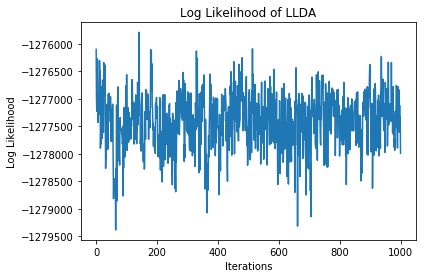

In [139]:
import matplotlib.pyplot as plt
plt.plot(log_likelihoods)
plt.xlabel('Iterations')
plt.ylabel('Log Likelihood')
plt.title('Log Likelihood of LLDA')
plt.savefig('llda.png', dpi=200)

In [140]:
beta = llda.calc_beta()
theta = llda.calc_theta()

In [141]:
beta.shape

(342, 12)

In [142]:
theta.shape

(50, 12)

In [143]:
np.unique(llda.z)

array([ 0,  2,  3,  4,  6,  7,  8, 10, 11])

In [144]:
np.unique(llda.z[3])

array([ 0,  8, 10])

In [145]:
theta[3]

array([1.59713793e-05, 1.59713793e-05, 1.59713793e-05, 1.59713793e-05,
       1.59713793e-05, 1.59713793e-05, 1.59713793e-05, 1.59713793e-05,
       8.00166102e-03, 1.59713793e-05, 9.59879895e-03, 1.59713793e-05])

### Get most common words

For topic 6:

In [146]:
import pandas as pd

In [147]:
word_freq_inds = np.argsort(llda.n_wk[:, 3]) #least to most
word_features = pd.Series(llda.corpus_model.get_feature_names())

In [148]:
word_freq_inds

array([  0, 229, 228, 227, 226, 225, 224, 223, 230, 222, 220, 219, 217,
       216, 215, 214, 213, 221, 231, 232, 233, 251, 250, 249, 248, 247,
       245, 244, 243, 242, 241, 240, 239, 238, 237, 236, 235, 234, 212,
       211, 210, 209, 186, 185, 184, 183, 182, 181, 180, 179, 178, 177,
       175, 174, 173, 172, 171, 169, 168, 187, 252, 188, 190, 208, 207,
       206, 205, 203, 202, 201, 200, 199, 198, 197, 196, 195, 194, 193,
       192, 191, 189, 253, 254, 255, 316, 315, 314, 313, 312, 311, 310,
       309, 308, 307, 306, 305, 304, 303, 302, 301, 300, 317, 299, 318,
       320, 339, 338, 337, 336, 335, 334, 333, 332, 330, 329, 327, 326,
       325, 324, 323, 322, 321, 319, 167, 298, 296, 272, 271, 270, 269,
       268, 267, 266, 265, 264, 263, 262, 261, 260, 259, 258, 257, 256,
       273, 297, 274, 276, 295, 294, 293, 292, 291, 290, 289, 287, 286,
       285, 284, 283, 282, 281, 279, 278, 277, 275, 166, 170, 164,  63,
        62,  61,  60,  58,  57,  56,  64,  55,  53,  52,  49,  4

In [149]:
word_features[word_freq_inds[-5:]]

288      this
71     devine
82        eat
280       the
218     price
dtype: object

### Get cluster assignments for documents

For document 0:

In [150]:
i = 0

word_inds = np.nonzero(llda.X[i])[1]
np.unique(llda.z[i, word_inds])

array([11])

In [151]:
llda.z.shape

(50, 342)

In [152]:
num_docs = llda.z.shape[0]

llda_doc_labels_pred = dict()
doc_labels = dict()
for i in range(0, num_docs):
    word_inds = np.nonzero(llda.X[i])[1]
    llda_doc_labels_pred[i] = np.unique(llda.z[i, word_inds])
    doc_labels[i] = np.nonzero(label_matrix[i])[0]

In [153]:
np.nonzero(label_matrix[0])[0]

array([11])

For each document, create a list of docs that are in the same cluster (labeled and inferred)

Compute TP, FP, FN values, then calculate precision, recall, and f-score

In [154]:
tp = 0
fp = 0
fn = 0
total = 0

for i in range(0, num_docs):
    pred_i = set(llda_doc_labels_pred[i])
    label_i = set(doc_labels[i])
    for j in range(0, num_docs):
        if i == j: continue
        pred_j = set(llda_doc_labels_pred[j])
        label_j = set(doc_labels[j])
        
        # If labeled in same cluster
        label_same_cluster = label_i.isdisjoint(label_j)
        # If predicted in same cluster
        pred_same_cluster = pred_i.isdisjoint(pred_j)
        
        if label_same_cluster == True and pred_same_cluster == True:
            tp += 1
        elif label_same_cluster == False and pred_same_cluster == True:
            fp += 1
        elif label_same_cluster == True and pred_same_cluster == False:
            fn += 1
        total += 1

In [155]:
precision = tp / (tp + fp)
recall = tp / (tp + fn)
fscore = (2 * precision * recall) / (precision + recall)

print(precision, recall, fscore)

0.9377049180327869 1.0 0.9678510998307953


In [156]:
metrics = []
for i in range(0, 5):
    log_likelihoods = llda.fit(max_iters=100)
    
    num_docs = llda.z.shape[0]

    llda_doc_labels_pred = dict()
    doc_labels = dict()
    for i in range(0, num_docs):
        word_inds = np.nonzero(llda.X[i])[1]
        llda_doc_labels_pred[i] = np.unique(llda.z[i, word_inds])
        doc_labels[i] = np.nonzero(label_matrix[i])[0]

    tp = 0
    fp = 0
    fn = 0
    total = 0

    for i in range(0, num_docs):
        pred_i = set(llda_doc_labels_pred[i])
        label_i = set(doc_labels[i])
        for j in range(0, num_docs):
            if i == j: continue
            pred_j = set(llda_doc_labels_pred[j])
            label_j = set(doc_labels[j])

            # If labeled in same cluster
            label_same_cluster = label_i.isdisjoint(label_j)
            # If predicted in same cluster
            pred_same_cluster = pred_i.isdisjoint(pred_j)

            if label_same_cluster == True and pred_same_cluster == True:
                tp += 1
            elif label_same_cluster == False and pred_same_cluster == True:
                fp += 1
            elif label_same_cluster == True and pred_same_cluster == False:
                fn += 1
            total += 1

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    fscore = (2 * precision * recall) / (precision + recall)

    print(precision, recall, fscore)
    metrics.append((precision, recall, fscore))

0
0.9387308533916849 1.0 0.9683972911963883
0
0.9522752497225305 1.0 0.9755542922114838
0
0.9377049180327869 1.0 0.9678510998307953
0
0.9512195121951219 1.0 0.975
0
0.9377049180327869 1.0 0.9678510998307953


# LDA

In [88]:
lda = LDA(0.01, 0.01, 12)

In [89]:
lda.random_initialization(review_data['review'][:50])
lda.vocab_size

252

In [90]:
print('n_dk: {}'.format(lda.n_dk.shape))
print('n_wk: {}'.format(lda.n_wk.shape))

n_dk: (50, 12)
n_wk: (252, 12)


In [91]:
label_matrix.shape

(1708, 12)

In [92]:
orig_z = lda.z

In [93]:
log_likelihoods = lda.fit(max_iters=1000)

0
100
200
300
400
500
600
700
800
900


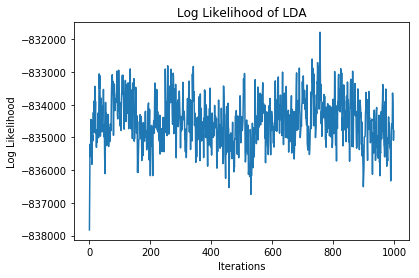

In [94]:
import matplotlib.pyplot as plt
plt.plot(log_likelihoods)
plt.xlabel('Iterations')
plt.ylabel('Log Likelihood')
plt.title('Log Likelihood of LDA')
plt.savefig('lda.png', dpi=200)

In [95]:
beta = lda.calc_beta()
theta = lda.calc_theta()

In [96]:
num_docs = lda.z.shape[0]

lda_doc_labels = dict()
for i in range(0, num_docs):
    word_inds = np.nonzero(llda.X[i])[1]
    doc_labels[i] = np.unique(llda.z[i, word_inds])

### Get most common words

For topic 6:

In [97]:
import pandas as pd

In [98]:
word_freq_inds = np.argsort(lda.n_wk[:, 3]) #least to most
word_features = pd.Series(lda.corpus_model.get_feature_names())

In [99]:
word_features[word_freq_inds[-5:]]

192        shrimp
17        awesome
67     experience
89          great
76           food
dtype: object

### Get cluster assignments for documents

For document 0:

In [100]:
i = 0

word_inds = np.nonzero(lda.X[i])[1]
np.unique(llda.z[i, word_inds])

array([0])

In [101]:
lda.z.shape

(50, 252)

In [102]:
num_docs = llda.z.shape[0]

lda_doc_labels_pred = dict()
doc_labels = dict()
for i in range(0, num_docs):
    word_inds = np.nonzero(lda.X[i])[1]
    lda_doc_labels_pred[i] = np.unique(lda.z[i, word_inds])
    doc_labels[i] = np.nonzero(label_matrix[i])[0]

In [103]:
np.nonzero(label_matrix[0])[0]

array([11])

For each document, create a list of docs that are in the same cluster (labeled and inferred)

Compute TP, FP, FN values, then calculate precision, recall, and f-score

In [104]:
tp = 0
fp = 0
fn = 0
total = 0

for i in range(0, num_docs):
    pred_i = set(lda_doc_labels_pred[i])
    label_i = set(doc_labels[i])
    for j in range(0, num_docs):
        if i == j: continue
        pred_j = set(lda_doc_labels_pred[j])
        label_j = set(doc_labels[j])
        
        # If labeled in same cluster
        label_same_cluster = label_i.isdisjoint(label_j)
        # If predicted in same cluster
        pred_same_cluster = pred_i.isdisjoint(pred_j)
        
        if label_same_cluster == True and pred_same_cluster == True:
            tp += 1
        elif label_same_cluster == False and pred_same_cluster == True:
            fp += 1
        elif label_same_cluster == True and pred_same_cluster == False:
            fn += 1
        total += 1

In [105]:
precision = tp / (tp + fp)
recall = tp / (tp + fn)
fscore = (2 * precision * recall) / (precision + recall)

print(precision, recall, fscore)

0.7152380952380952 0.8752913752913752 0.7872117400419286


In [132]:
metrics = []
for i in range(0, 5):
    log_likelihoods = lda.fit(max_iters=100)

    num_docs = llda.z.shape[0]

    lda_doc_labels_pred = dict()
    doc_labels = dict()
    for i in range(0, num_docs):
        word_inds = np.nonzero(lda.X[i])[1]
        lda_doc_labels_pred[i] = np.unique(lda.z[i, word_inds])
        doc_labels[i] = np.nonzero(label_matrix[i])[0]
    
    tp = 0
    fp = 0
    fn = 0
    total = 0

    for i in range(0, num_docs):
        pred_i = set(lda_doc_labels_pred[i])
        label_i = set(doc_labels[i])
        for j in range(0, num_docs):
            if i == j: continue
            pred_j = set(lda_doc_labels_pred[j])
            label_j = set(doc_labels[j])

            # If labeled in same cluster
            label_same_cluster = label_i.isdisjoint(label_j)
            # If predicted in same cluster
            pred_same_cluster = pred_i.isdisjoint(pred_j)

            if label_same_cluster == True and pred_same_cluster == True:
                tp += 1
            elif label_same_cluster == False and pred_same_cluster == True:
                fp += 1
            elif label_same_cluster == True and pred_same_cluster == False:
                fn += 1
            total += 1

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    fscore = (2 * precision * recall) / (precision + recall)

    print(precision, recall, fscore)
    metrics.append((precision, recall, fscore))

0
0.7134670487106017 0.8706293706293706 0.784251968503937
0
0.723384030418251 0.8869463869463869 0.7968586387434556
0
0.7152380952380952 0.8752913752913752 0.7872117400419286
0
0.7160148975791434 0.8962703962703963 0.7960662525879917
0
0.7231695085255767 0.8403263403263403 0.7773584905660377


# Scratch Space

In [ ]:
lda.corpus_model.get_feature_names()

In [ ]:
where = np.argwhere(label_matrix[:50] == 1).T[0]
where = np.nonzero(label_matrix[:50])
where[1]

In [ ]:
label_matrix[3]